# Data Creation / Curation

In [ ]:
import os, re
import pandas as pd
import geopandas as gpd

data_dir = './work/'

## Jaipur Boundary

Jaipur data CRS is EPSG:32643


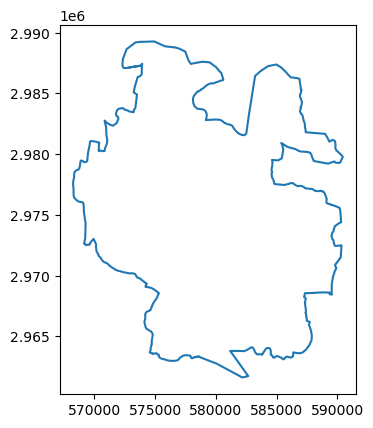

In [ ]:
jp = gpd.read_file('./data/Jaipur_Boundary/18JMC.shp')
jp.plot()
jp.to_parquet(f'{data_dir}/Jaipur_Boundary.geoparquet')
print(f"Jaipur data CRS is {jp.crs}")

Note, however, that OSM data uses a different projection, so the below link returns an error.

In [4]:
bounds = jp.bounds
print(f"https://api.openstreetmap.org/api/0.6/map?bbox={bounds.minx[0]:0.3f},{bounds.miny[0]:0.3f},{bounds.maxx[0]:0.3f},{bounds.maxy[0]:0.3f}")

https://api.openstreetmap.org/api/0.6/map?bbox=568250.136,2961611.977,590450.900,2989266.225


So we can reproject Jaipur into the OSM default EPSG projection.

Jaipur data CRS is EPSG:4326


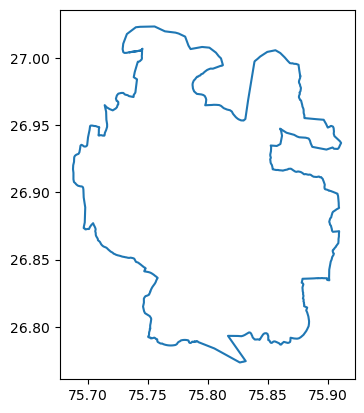

In [5]:
jpr = jp.to_crs('EPSG:4326')
jpr.plot()
print(f"Jaipur data CRS is {jpr.crs}")

This link will now work to show the area of Jaipur in OSM.

In [6]:
bounds = jpr.bounds
print(f"https://api.openstreetmap.org/api/0.6/map?bbox={bounds.minx[0]:0.3f},{bounds.miny[0]:0.3f},{bounds.maxx[0]:0.3f},{bounds.maxy[0]:0.3f}")

https://api.openstreetmap.org/api/0.6/map?bbox=75.687,26.773,75.911,27.024


But perhaps it would be better to buffer the boundary so that roads aren't cut off *right* at the border of the city? However, can you spot what is wrong with the map below? Why is the middle of Jaipur still white and not filled in with grey?

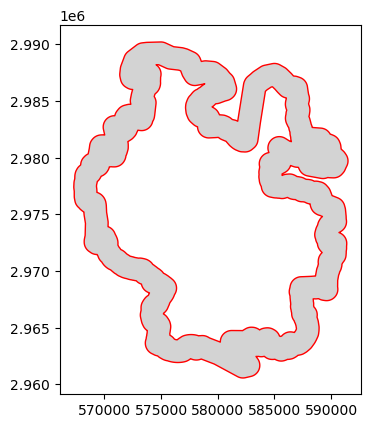

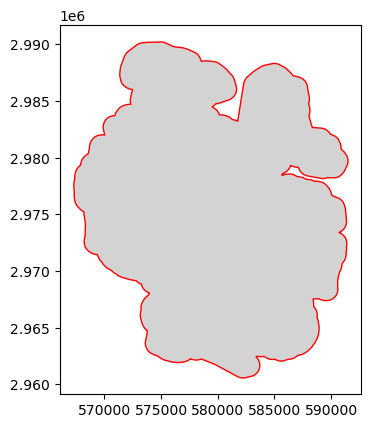

In [31]:
jp.buffer(1000).plot(color='lightgrey', edgecolor='red')

Luckily, there's some code to solve that for us!

In [ ]:
polygons, cuts, dangles, invalid = jp.polygonize(full=True)
polygons.buffer(1000).plot(color='lightgrey', edgecolor='red')
jpdf = gpd.GeoDataFrame({'city':['Jaipur'], 'geometry':polygons})

## Jaipur Wards

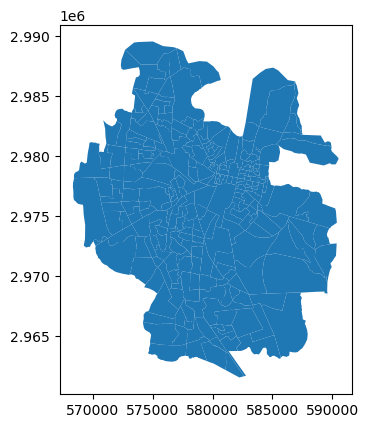

In [ ]:
path  = os.path.join('.','data','Jaipur_Wards')
wards = [os.path.join(path,x) for x in os.listdir(path) if x.endswith('.shp')]

wgdf  = gpd.GeoDataFrame(pd.concat([gpd.read_file(w) for w in wards], ignore_index=True), crs=gpd.read_file(wards[0]).crs)
wgdf.plot()
wgdf.to_parquet(f'{data_dir}Jaipur_Wards.geoparquet')

## OSM Data for Jaipur

OSM layer types are 'points' (default), 'lines', 'multilinestrings', 'multipolygons', 'other_relations'.

In [49]:
jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds

(75.63706354162673, 26.728331722010523, 75.96149101624788, 27.06866127593459)

In [ ]:
gpd.read_file('./data/OSM/northern-zone-latest.osm.pbf',
             engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='lines'
        ).to_parquet(f'{data_dir}northern-zone-lines.geoparquet')

In [ ]:
gpd.read_file('./data/OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='points'
        ).to_parquet(f'{data_dir}northern-zone-points.geoparquet')

In [ ]:
gpd.read_file('./data/OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='multipolygons'
        ).to_parquet(f'{data_dir}northern-zone-multipolygons.geoparquet')

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:337: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  table = reader.read_all()


In [ ]:
gpd.read_file('./data/OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='multilinestrings'
        ).to_parquet(f'{data_dir}northern-zone-multilines.geoparquet')

In [ ]:
gpd.read_file('./data/OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='other_relations'
        ).to_parquet('./work/northern-zone-other.geoparquet')

## Census Data

This section shows how code allows us to deal with complex tables in a way that is reproducible and verifiable: we don't need to wonder where a field came from or how it was derived, we can *see* in the code what happened and judge accordingly. Handling this in ArcGIS would require manual copying and pasting of data into new tables and that is the point where errors can sneak in. A slip of the finger and columns are transposed or other errors introduced.

What makes this section particularly tricky is that we're dealing with *hierarchical* columns: there are columnar groups of data (e.g. housing condition, access to sewerage, etc.) that relate to a single theme. We want to keep those together while also making the data a little easier to handle. But when we first load this data what we see is lots of "Unnamed: X_level_Y" values in bold and it looks like we've made a mistake!

In [ ]:
df = pd.read_excel(
    './data/Wardwise/households/HLPCA-08110-2011_H14_census.xlsx', 
    sheet_name='Housing', 
    header=[2,3,4,5]
)

df.head(2)

State Code         State Name      District Code      District Name  \
  Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1 Unnamed: 3_level_1   
  Unnamed: 0_level_2 Unnamed: 1_level_2 Unnamed: 2_level_2 Unnamed: 3_level_2   
                 1                  2                  3                  4     
0                  8          RAJASTHAN                110            Jaipur    
1                  8          RAJASTHAN                110            Jaipur    

         Tehsil Code        Tehsil Name Town Code/Village code  \
  Unnamed: 4_level_1 Unnamed: 5_level_1     Unnamed: 6_level_1   
  Unnamed: 4_level_2 Unnamed: 5_level_2     Unnamed: 6_level_2   
                 5                  6                      7     
0                546             Jaipur                 800522   
1                546             Jaipur                 800522   

             Ward No                            Area Name      Rural/\nUrban  \
  Unnamed: 7_level_1                   Unnamed: 8_level_1 Unnamed: 9_level_1   
  Unnamed: 7_level_2                   Unnamed: 8_level_2 Unnamed: 9_level_2   
                 8                                    9                  10    
0                  1  Jaipur (M Corp.) (Part) - Ward No.1              Urban   
1                  2  Jaipur (M Corp.) (Part) - Ward No.2              Urban   

   ...    Availability of assets                       \
   ... Scooter/ Motorcycle/Moped        Car/ Jeep/Van   
   ...      Unnamed: 135_level_2 Unnamed: 136_level_2   
   ...                       136                  137   
0  ...                      46.1                  8.5   
1  ...                      62.7                 11.3   

                                                                                \
  Households with TV, Computer/Laptop, Telephone/mobile phone and Scooter/ Car   
                                                          Unnamed: 137_level_2   
                                                                           138   
0                                                7.3                             
1                                               15.3                             

                                                 \
  None of the assets specified in col. 10 to 19   
                           Unnamed: 138_level_2   
                                            139   
0                                           4.4   
1                                           1.4   

  Households by Type of Structure of Census Houses                       \
                              Unnamed: 139_level_1 Unnamed: 140_level_1   
                                         Permanent       Semi-Permanent   
                                               140                  141   
0                                             94.6                  2.9   
1                                             96.4                  1.8   

                                                                  \
  Unnamed: 141_level_1 Unnamed: 142_level_1 Unnamed: 143_level_1   
       Total Temporary          Serviceable      Non-Serviceable   
                   142                  143                  144   
0                  0.5                  0.1                  0.4   
1                  0.0                  0.0                  0.0   

                        
  Unnamed: 144_level_1  
        Unclassifiable  
                   145  
0                  1.9  
1                  1.7  

[2 rows x 145 columns]

### Dealing with MultiIndexes

This retrieves a single group of columns from the 'top' level of the hierarchy: all columns relating the 'availability of assets'.

In [33]:
df.loc[:,(['Availability of assets'])].head(2)

Availability of assets                                       \
      Radio/\nTransistor           Television Computer/Laptop   
    Unnamed: 127_level_2 Unnamed: 128_level_2   With Internet   
                     128                  129             130   
0                   33.8                 78.7             2.6   
1                   46.1                 87.2             4.8   

                                                            \
                   Telephone/Mobile Phone                    
  Without Internet          Landline only Mobile only Both   
               131                    132         133  134   
0              8.7                    3.0        83.8  2.9   
1             14.5                    3.7        85.3  7.2   

                                                                       \
               Bicycle Scooter/ Motorcycle/Moped        Car/ Jeep/Van   
  Unnamed: 134_level_2      Unnamed: 135_level_2 Unnamed: 136_level_2   
                   135                       136                  137   
0                 42.5                      46.1                  8.5   
1                 57.1                      62.7                 11.3   

                                                                                \
  Households with TV, Computer/Laptop, Telephone/mobile phone and Scooter/ Car   
                                                          Unnamed: 137_level_2   
                                                                           138   
0                                                7.3                             
1                                               15.3                             

                                                 
  None of the assets specified in col. 10 to 19  
                           Unnamed: 138_level_2  
                                            139  
0                                           4.4  
1                                           1.4

This retrieves a group of columns from the 'bottom' level of the hierarchy: all columns in the range from 125 to 139. So we need to tell Python that we're not interested in levels 1, 2, or 3, just the columns numbered 125..139. That's why you'll see `slice(None)` there.

In [34]:
df.loc[:,(slice(None), slice(None), slice(None), range(125,140))].head(2)

Kitchen facility                       \
  Does not have kitchen           No Cooking   
   Unnamed: 124_level_2 Unnamed: 125_level_2   
                    125                  126   
0                   2.1                  0.3   
1                   1.1                  0.3   

  Total number of households availing banking services Availability of assets  \
                                  Unnamed: 126_level_1     Radio/\nTransistor   
                                  Unnamed: 126_level_2   Unnamed: 127_level_2   
                                                   127                    128   
0                                               68.5                     33.8   
1                                               81.1                     46.1   

                                                         \
            Television Computer/Laptop                    
  Unnamed: 128_level_2   With Internet Without Internet   
                   129             130              131   
0                 78.7             2.6              8.7   
1                 87.2             4.8             14.5   

                                                                \
  Telephone/Mobile Phone                               Bicycle   
           Landline only Mobile only Both Unnamed: 134_level_2   
                     132         133  134                  135   
0                    3.0        83.8  2.9                 42.5   
1                    3.7        85.3  7.2                 57.1   

                                                  \
  Scooter/ Motorcycle/Moped        Car/ Jeep/Van   
       Unnamed: 135_level_2 Unnamed: 136_level_2   
                        136                  137   
0                      46.1                  8.5   
1                      62.7                 11.3   

                                                                                \
  Households with TV, Computer/Laptop, Telephone/mobile phone and Scooter/ Car   
                                                          Unnamed: 137_level_2   
                                                                           138   
0                                                7.3                             
1                                               15.3                             

                                                 
  None of the assets specified in col. 10 to 19  
                           Unnamed: 138_level_2  
                                            139  
0                                           4.4  
1                                           1.4

Here's how we get a list of all the top-level values, you get one value for *each* column, so that's why you see `'Households by Type of Structure of Census Houses'` repeated multiple times.

In [35]:
df.columns.get_level_values(0)

Index(['State Code', 'State Name', 'District Code', 'District Name',
       'Tehsil Code', 'Tehsil Name', 'Town Code/Village code', 'Ward No',
       'Area Name', 'Rural/\nUrban',
       ...
       'Availability of assets', 'Availability of assets',
       'Availability of assets', 'Availability of assets',
       'Households by Type of Structure of Census Houses',
       'Households by Type of Structure of Census Houses',
       'Households by Type of Structure of Census Houses',
       'Households by Type of Structure of Census Houses',
       'Households by Type of Structure of Census Houses',
       'Households by Type of Structure of Census Houses'],
      dtype='object', length=145)

The first 9 columns (skipping the empty first column) are 'required' for linking the data to other data sets. We're going to stash those in a list variable called `required`. For the rest, we're going to ask for the *unique* top-level values and print them out so that we can create our own groups. Notice that we check for a *really* annoying problem that often crops up with data: invisible characters in a column name that always give mapping software fits.

In [62]:
required = df.columns.get_level_values(0).to_list()[0:10]
print(f"These fields are required for matching: '{"', '".join(required)}'")
print()
print(f"These are the top-level columns groups in the data...")
for c in set(df.columns.get_level_values(0).to_list()[10:]):
    print(f"'{c}'")
    if c.strip() != c:
        print("^^^^^ Watch out, there are hidden characters here! ^^^^^^")

These fields are required for matching: 'State Code', 'State Name', 'District Code', 'District Name', 'Tehsil Code', 'Tehsil Name', 'Town Code/Village code', 'Ward No', 'Area Name', 'Rural/
Urban'

These are the top-level columns groups in the data...
'Location of drinking water source'
'Household size'
'Material of Roof'
'Households by Type of Structure of Census Houses'
'Pit latrine'
'Ownership status'
'Number of households not having latrine facility within the premises'
'Married couple'
'Total number of households availing banking services'
'Number of households having latrine facility within the premises'
'Service Latrine'
'Type of Fuel used for Cooking'
'Availability of assets'
'Number of Dwelling Rooms'
'Kitchen facility'
'Main Source of lighting'
'Flush/pour flush latrine connected to'
'Number of households having bathing facility within the premises'
'Alternative source'
'Main Source of Drinking Water'
'Waste water outlet connected to'
'Number of households with condition of C

We're going to create a 'map' (in the sense of connections) between the column groups and an output file here, so the 'condition' output file will contain all columns from the `'Number of households with condition of Census House as '` group. And so on. At this point it's worth remembering that the lowest level of the column groupings is just a unique number between 1 and 145... which might be useful as a short-cut but can't be used as the label itself!

### Rewriting and Outputting Column Labels

In [63]:
output_map = {
    'condition': ['Number of households with condition of Census House as '],
    'materials': ['Material of Roof','Material of Wall','Material of Floor'],
    'occupancy': ['Number of Dwelling Rooms','Household size','Ownership status','Married couple'],
    'utilities': ['Main Source of Drinking Water','Location of drinking water source','Main Source of lighting', 
                  'Number of households having latrine facility within the premises','Flush/pour flush latrine connected to','Pit latrine', 
                  'Night soil disposed into open drain\n','Service Latrine','Number of households not having latrine facility within the premises',
                  'Alternative source','Number of households having bathing facility within the premises','Waste water outlet connected to',
                  'Type of Fuel used for Cooking','Kitchen facility'],
    'assets':    ['Total number of households availing banking services','Availability of assets'],
    'structure': ['Households by Type of Structure of Census Houses']
}

In [ ]:
for k,v in output_map.items():
    
    print(f"Creating data file for '{k}' columns...")
    
    tmp = df.loc[:,required+v]
    print("Done.")
    cols = tmp.columns
    new_cols = [x.replace('\n','').strip() for x in required] # Our new column labels
    for c in cols:
        print(c)
        idx = c[-1] # Short-hand for the last item in the list, which is the lowest level
        nms = [x for x in c[:-1] if not x.startswith('Unnamed') and not x in v]
        print(nms)
        lbl = f"{idx}: {'-'.join(re.sub(r'\W+','_',x.strip().lower()) for x in nms)}"
        print(lbl)
        print()
    tmp.to_parquet(f'{data_dir}{k}.parquet')
    break

Creating data file for 'condition' columns...
Done.
('State Code', 'Unnamed: 0_level_1', 'Unnamed: 0_level_2', 1)
['State Code']
1: state_code

('State Name', 'Unnamed: 1_level_1', 'Unnamed: 1_level_2', 2)
['State Name']
2: state_name

('District Code', 'Unnamed: 2_level_1', 'Unnamed: 2_level_2', 3)
['District Code']
3: district_code

('District Name', 'Unnamed: 3_level_1', 'Unnamed: 3_level_2', 4)
['District Name']
4: district_name

('Tehsil Code', 'Unnamed: 4_level_1', 'Unnamed: 4_level_2', 5)
['Tehsil Code']
5: tehsil_code

('Tehsil Name', 'Unnamed: 5_level_1', 'Unnamed: 5_level_2', 6)
['Tehsil Name']
6: tehsil_name

('Town Code/Village code', 'Unnamed: 6_level_1', 'Unnamed: 6_level_2', 7)
['Town Code/Village code']
7: town_code_village_code

('Ward No', 'Unnamed: 7_level_1', 'Unnamed: 7_level_2', 8)
['Ward No']
8: ward_no

('Area Name', 'Unnamed: 8_level_1', 'Unnamed: 8_level_2', 9)
['Area Name']
9: area_name

('Rural/\nUrban', 'Unnamed: 9_level_1', 'Unnamed: 9_level_2', 10)
['Rura

## Population Data

In [ ]:
pop = pd.read_excel(
    './data/Wardwise/population/wardwise population data as per 2011 census.xlsx'
)
print(f"Loaded {pop.shape} cells")
pop.head(2)

Loaded (2561, 94) cells


,State,District,Subdistt,Town/Village,Ward,EB,Level,Name,TRU,No_HH,...,MARG_AL_0_3_F,MARG_HH_0_3_P,MARG_HH_0_3_M,MARG_HH_0_3_F,MARG_OT_0_3_P,MARG_OT_0_3_M,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F
0,8,110,0,0,0,0,DISTRICT,Jaipur,Total,1177096,...,6775,4002,1405,2597,32114,13016,19098,4161285,1753560,2407725
1,8,110,0,0,0,0,DISTRICT,Jaipur,Rural,507803,...,6053,2390,746,1644,22425,7181,15244,1807672,855473,952199
2,8,110,0,0,0,0,DISTRICT,Jaipur,Urban,669293,...,722,1612,659,953,9689,5835,3854,2353613,898087,1455526
3,8,110,538,0,0,0,SUB-DISTRICT,Kotputli,Total,69470,...,1092,120,43,77,1533,710,823,250857,117413,133444
4,8,110,538,0,0,0,SUB-DISTRICT,Kotputli,Rural,61396,...,1037,110,36,74,1398,600,798,215446,102706,112740


In [ ]:
pop = pd.read_excel(
    './data/Wardwise/population/wardwise population data as per 2011 census.xlsx'
)
print(f"Loaded {pop.shape} cells")
pop.head(2)

Loaded (2561, 94) cells


,State,District,Subdistt,Town/Village,Ward,EB,Level,Name,TRU,No_HH,...,MARG_AL_0_3_F,MARG_HH_0_3_P,MARG_HH_0_3_M,MARG_HH_0_3_F,MARG_OT_0_3_P,MARG_OT_0_3_M,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F
0,8,110,0,0,0,0,DISTRICT,Jaipur,Total,1177096,...,6775,4002,1405,2597,32114,13016,19098,4161285,1753560,2407725
1,8,110,0,0,0,0,DISTRICT,Jaipur,Rural,507803,...,6053,2390,746,1644,22425,7181,15244,1807672,855473,952199
2,8,110,0,0,0,0,DISTRICT,Jaipur,Urban,669293,...,722,1612,659,953,9689,5835,3854,2353613,898087,1455526
3,8,110,538,0,0,0,SUB-DISTRICT,Kotputli,Total,69470,...,1092,120,43,77,1533,710,823,250857,117413,133444
4,8,110,538,0,0,0,SUB-DISTRICT,Kotputli,Rural,61396,...,1037,110,36,74,1398,600,798,215446,102706,112740


In [3]:
# Then need to filter down for Jaipur
jpop = pop[pop.Name.str.contains('Jaipur (M Corp.)', regex=False)]

print(f"Extracted {jpop.shape} cells")
jpop.head(2) # Note the levels

Extracted (80, 94) cells


,State,District,Subdistt,Town/Village,Ward,EB,Level,Name,TRU,No_HH,...,MARG_AL_0_3_F,MARG_HH_0_3_P,MARG_HH_0_3_M,MARG_HH_0_3_F,MARG_OT_0_3_P,MARG_OT_0_3_M,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F
1421,8,110,545,800522,0,0,TOWN,Jaipur (M Corp.) (Part),Urban,153252,...,122,330,131,199,1673,929,744,511418,199749,311669
1422,8,110,545,800522,24,0,WARD,Jaipur (M Corp.) (Part) WARD NO.-0024,Urban,9395,...,2,6,3,3,47,29,18,30593,11757,18836
1423,8,110,545,800522,25,0,WARD,Jaipur (M Corp.) (Part) WARD NO.-0025,Urban,6800,...,3,13,5,8,96,49,47,22654,8521,14133
1424,8,110,545,800522,26,0,WARD,Jaipur (M Corp.) (Part) WARD NO.-0026,Urban,7023,...,0,8,2,6,46,25,21,20726,7464,13262
1425,8,110,545,800522,27,0,WARD,Jaipur (M Corp.) (Part) WARD NO.-0027,Urban,9177,...,0,6,2,4,46,24,22,26361,10046,16315


In [ ]:
jpop.to_parquet('./work/population.parquet', index=False)